In [1]:
import itertools
import json
import pandas as pd
import numpy as np
from soil_roughness_change_detection.modules.outlier_detectors import (
    dbscan_outlier_detector,
    mahalanobis_distance_outlier_detector,
    isolation_forest_outlier_detector
)
from soil_roughness_change_detection.modules.experiment import run_experiment
from soil_roughness_change_detection.modules.preprocessor import (
    preprocess_backscatter,
    preprocess_harrysfarm_activity_log
)
import matplotlib.pyplot as plt

%matplotlib inline

## Config

In [2]:
training_period_from = '2018-12-31'
training_period_to = '2020-12-31'
testing_period_to = '2022-12-31'
s1_file_path = './data/harrysfarm/harrysfarm_fields_s1_grd.pkl'
farm_activity_annotation_path = './data/harrysfarm_tillage_activity.csv'
random_state = 123

## Preprocessed Sentinel 1 Backscatter Data

In [3]:
df = pd.read_pickle(s1_file_path)
training_df, testing_df = preprocess_backscatter(
    df,
    training_period_from=training_period_from,
    training_period_to=training_period_to,
    testing_period_from=training_period_to,
    testing_period_to=testing_period_to,
    # is_normalized_to_38_degree=True,
    is_group_by_orbit=True
)
training_interval_df = training_df.reset_index()[['from_date', 'date']]\
    .groupby(['from_date', 'date']).first().reset_index()

testing_interval_df = testing_df.reset_index()[['from_date', 'date']]\
    .groupby(['from_date', 'date']).first().reset_index()

In [4]:
print("Number of training dates:", training_df.reset_index().date.unique().shape[0])
print("Number of training fields:", training_df.reset_index().field_id.unique().shape[0])
print("Number of testing dates:", testing_df.reset_index().date.unique().shape[0])
print("Number of testing fields:", testing_df.reset_index().field_id.unique().shape[0])

Number of training dates: 359
Number of training fields: 196
Number of testing dates: 269
Number of testing fields: 196


## Preprocess Harrys Farm Activity Data

In [5]:
tillage_df = pd.read_csv(farm_activity_annotation_path)

train_tillage_df, test_tillage_df = preprocess_harrysfarm_activity_log(
    tillage_df,
    training_period_from=training_period_from,
    training_period_to=training_period_to,
    testing_period_from=training_period_to,
    testing_period_to=testing_period_to,
)
print('Number of training events:', train_tillage_df.shape[0])
print('Number of testing events:', test_tillage_df.shape[0])

Number of training events: 31
Number of testing events: 41


## Models

### DBSCAN

In [6]:
dbscan_experiment_config = dict(
    name = 'dbscan',
    detector = dbscan_outlier_detector,
    parameter_spaces = [{
      "eps": 1.0,
      "min_samples": 10,
      "metric": "euclidean",
      "leaf_size": 10,
      "n_jobs": -1
    }],
    features = ['VV_diff', 'VH_diff']
)

In [147]:
testing_df.reset_index().date.unique().tolist()[250]

Timestamp('2022-10-19 00:00:00')

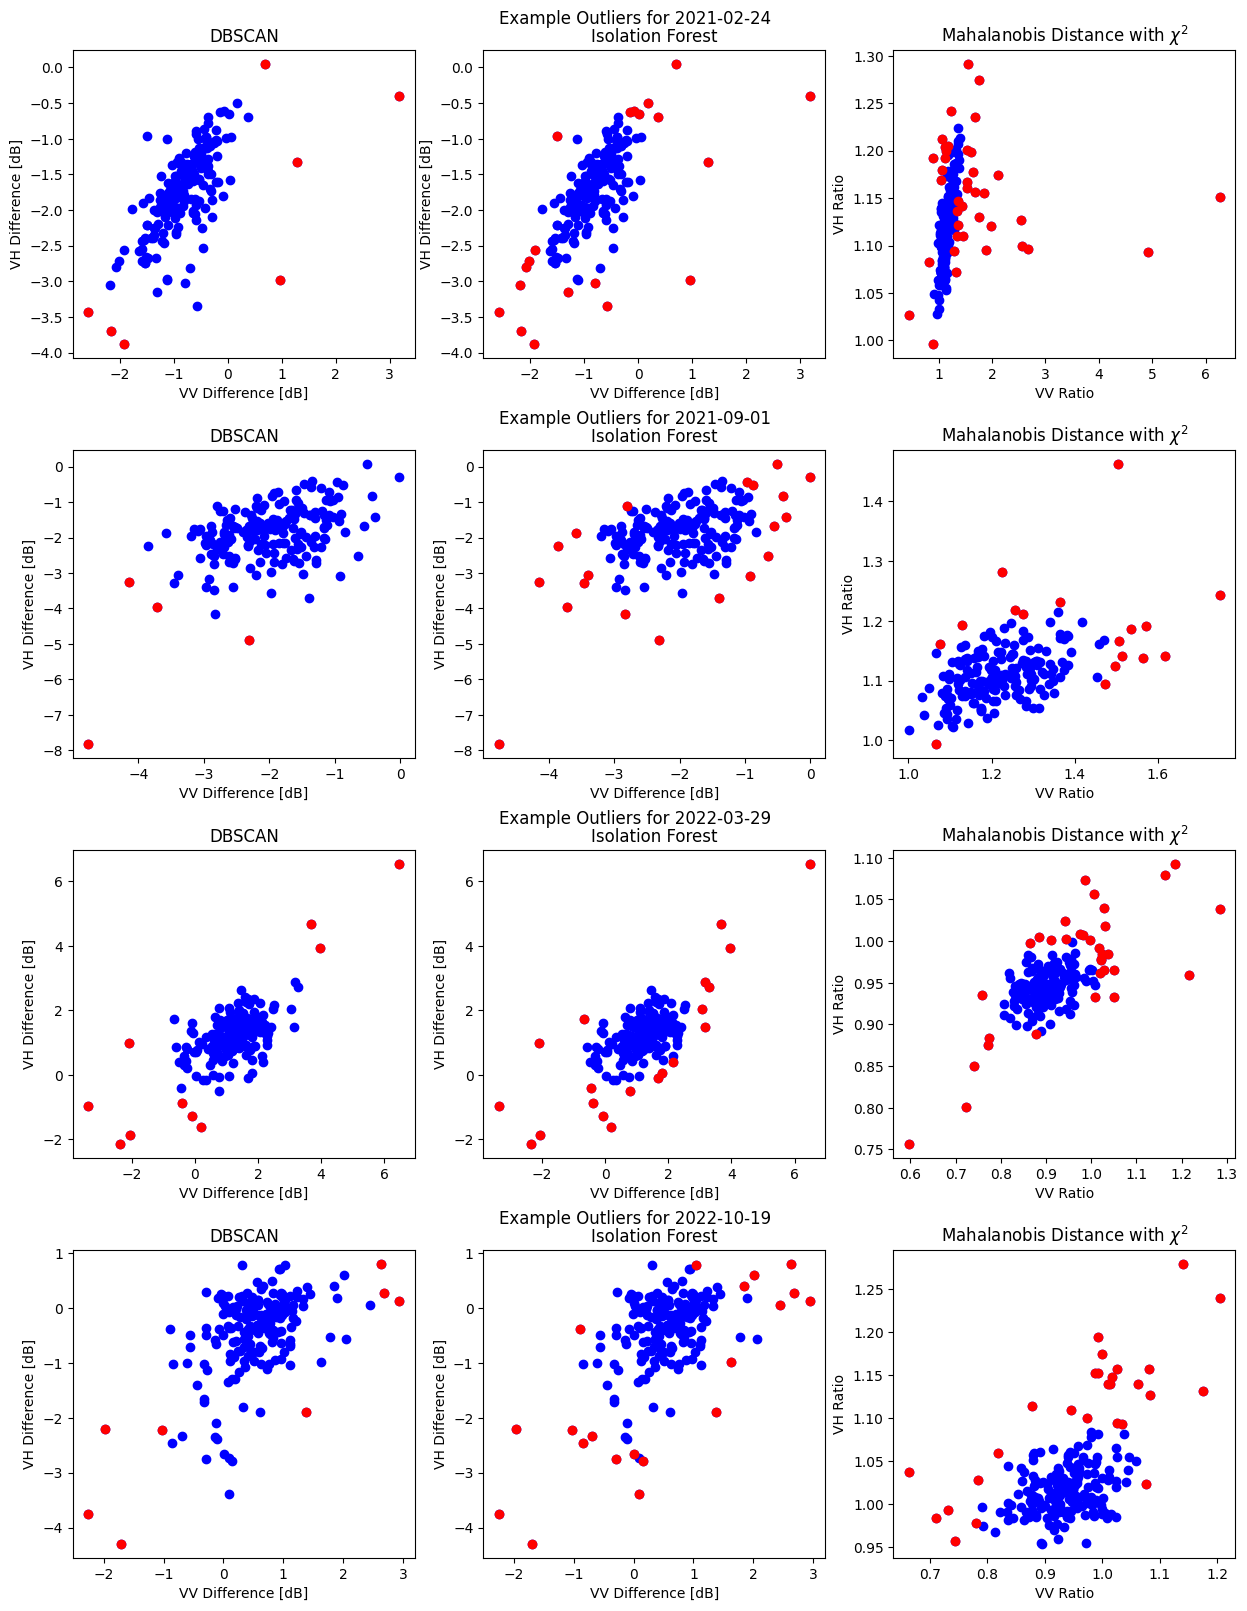

In [148]:
dates = [
    '2021-02-24',
    '2021-09-01',
    '2022-03-29',
    '2022-10-19'
]

fig = plt.figure(figsize=(15, 4 * len(dates)))
# fig.suptitle(f'Example of detected outliers')
subfigs = fig.subfigures(len(dates), 1)


for idx, date in enumerate(dates):
    axes = subfigs[idx].subplots(1, 3)
    subfigs[idx].suptitle(f'Example Outliers for {date}')
    dbscan_input_df = testing_df.xs(date, level=0)[['VV_diff', 'VH_diff']]

    dbscan_mask = dbscan_outlier_detector(dbscan_input_df.values, {
        "eps": 1.0,
        "min_samples": 10,
        "metric": "euclidean",
        "leaf_size": 10,
        "n_jobs": -1
        })
    axes[0].scatter(
        dbscan_input_df.VV_diff,
        dbscan_input_df.VH_diff,
        color='blue'
    )
    axes[0].scatter(
        dbscan_input_df[dbscan_mask].VV_diff,
        dbscan_input_df[dbscan_mask].VH_diff,
        color='red'
    )
    axes[0].set_xlabel('VV Difference [dB]')
    axes[0].set_ylabel('VH Difference [dB]')
    axes[0].set_title(f'DBSCAN')

    isolation_forest_input_df = testing_df.xs(date, level=0)[['VV_diff', 'VH_diff']]
    isolation_forest_mask = isolation_forest_outlier_detector(isolation_forest_input_df.values, {
        "n_estimators": 50,
        "contamination": 0.1,
        "n_jobs": -1,
        "random_state": 123
    })
    axes[1].scatter(
        isolation_forest_input_df.VV_diff,
        isolation_forest_input_df.VH_diff,
        color='blue'
    )
    axes[1].scatter(
        isolation_forest_input_df[isolation_forest_mask].VV_diff,
        isolation_forest_input_df[isolation_forest_mask].VH_diff,
        color='red'
    )
    axes[1].set_xlabel('VV Difference [dB]')
    axes[1].set_ylabel('VH Difference [dB]')
    axes[1].set_title(f'Isolation Forest')

    mahalanobis_input_df = testing_df.xs(date, level=0)[['VV_ratio', 'VH_ratio']]
    mahalanobis_mask = mahalanobis_distance_outlier_detector(mahalanobis_input_df.values, {
    "alpha": 0.01
    })
    # print(input_df[mask])
    axes[2].scatter(
        mahalanobis_input_df.VV_ratio,
        mahalanobis_input_df.VH_ratio,
        color='blue'
    )
    axes[2].scatter(
        mahalanobis_input_df[mahalanobis_mask].VV_ratio,
        mahalanobis_input_df[mahalanobis_mask].VH_ratio,
        color='red'
    )
    axes[2].set_xlabel('VV Ratio')
    axes[2].set_ylabel('VH Ratio')
    axes[2].set_title(f'Mahalanobis Distance with $\\chi^2$')

### Mahalanobis Distance with $\chi^2$

In [7]:
mahalanobis_experiment_config = dict(
    name = 'mahalanobis',
    detector = mahalanobis_distance_outlier_detector,
    parameter_spaces = [{
      "alpha": 0.01
    }],
    features = ['VV_ratio', 'VH_ratio']
)

### Isolation Forest

In [8]:
isolation_forest_experiment_config = dict(
    name = 'isolation_forest',
    detector = isolation_forest_outlier_detector,
    parameter_spaces = [{
      "n_estimators": 50,
      "contamination": 0.1,
      "n_jobs": -1,
      "random_state": 123
    }],
    features = ['VV_diff', 'VH_diff'],
)

## Visualization